# Modelo de texto para predicción de viabilidad de startups

En este notebook se entrena y evalúa un modelo **solo con la columna de texto
`descripcion`** para predecir la viabilidad de startups (`viabilidad` ∈ {0,1}).

El flujo general es:

1. Cargar el dataset procesado (`startups_sintetico_15000_processed.csv`).
2. Dividir en entrenamiento y prueba.
3. Entrenar un modelo TF-IDF + Regresión Logística (con señales numéricas en el texto).
4. Evaluar métricas (ROC-AUC, F1, matriz de confusión).
5. Buscar umbrales de decisión razonables.
6. Probar explicaciones con `explicar_texto`.
7. Guardar el modelo entrenado en `models/modelo_texto.joblib`.

## 1. Importación de librerías y configuración básica

Primero se importan las librerías necesarias y se detecta la raíz del proyecto
para poder importar módulos de `src/` sin problemas aunque el notebook se
ejecute desde la carpeta `notebooks/`.

In [45]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from joblib import dump

RANDOM_STATE = 42

# Detectar raíz del proyecto (para correr desde /notebooks sin romper rutas)
PROJECT_ROOT = next(
    p for p in [Path.cwd(), *Path.cwd().parents]
    if (p / "src").exists() and (p / "data").exists()
)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print("Proyecto raíz:", PROJECT_ROOT)

Proyecto raíz: c:\Users\carlo\OneDrive\Escritorio\Proyecto Machine Learning


## 2. Carga del dataset procesado

Se utiliza el archivo procesado con 15 000 filas:
`data/processed/startups_sintetico_15000_processed.csv`.

De este dataset solo se usan:

- `descripcion` → texto de la startup.
- `viabilidad` → etiqueta binaria (0 = no viable, 1 = viable).


In [46]:
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed" / "startups_sintetico_15000_processed.csv"

df = pd.read_csv(DATA_PROCESSED, encoding="utf-8")
assert {"descripcion", "viabilidad"}.issubset(df.columns), "Faltan columnas 'descripcion' y/o 'viabilidad'."

X_text = df["descripcion"].astype(str)
y = df["viabilidad"].astype(int)

print("Shape total:", df.shape)
print("\nDistribución de la variable objetivo (viabilidad):")
display(y.value_counts(normalize=True).rename("proporción"))

Shape total: (15000, 51)

Distribución de la variable objetivo (viabilidad):


viabilidad
1    0.576
0    0.424
Name: proporción, dtype: float64

## 3. División en entrenamiento y prueba

Se divide el conjunto en:

- 80% entrenamiento
- 20% prueba

Se usa `stratify=y` para mantener la proporción de clases.


In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X_text,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE,
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (12000,) Test: (3000,)


## 4. Transformación de texto: TF-IDF + señales numéricas

El modelo de texto se basa en:

- `TfidfVectorizer` con:
  - `ngram_range=(1,2)`
  - `max_features=1500`
  - `strip_accents="unicode"`
  - `stopwords` en español
  - `token_pattern` que acepta tokens como `25k`, `12%`, `350k`, etc.
  - `preprocessor` que enriquece el texto con tags especiales:
    - `__monto_pequeno__`, `__monto_medio__`, `__monto_alto__`, `__monto_muy_alto__`
    - `__clientes_bajos__`, `__clientes_medios__`, `__clientes_altos__`, `__muchos_clientes__`
    - `__crecimiento_bajo__`, `__crecimiento_medio__`, `__crecimiento_alto__`, `__crecimiento_explosivo__`
    - `__tiene_mrr__`, `__sin_clientes__`, `__sin_ingresos__`, `__fase_idea__`, etc.

- `LogisticRegression` con:
  - `class_weight="balanced"`
  - `max_iter=2000`
  - `random_state=42`

In [48]:
import re

# Stopwords básicas en español (se puede ajustar según necesidad)
STOP_ES = {
    "a","ante","bajo","con","contra","de","desde","durante","en","entre","hacia",
    "hasta","para","por","según","sin","sobre","tras","el","la","los","las","un",
    "una","unos","unas","lo","al","del","y","o","u","e","que","se","su","sus",
    "es","son","ser","fue","han","ha","como","más","menos","muy","ya","no","sí",
    "si","pero","también","porque","cuando","este","esta","estos","estas"
}

# Reutilizamos la misma función de preprocesamiento que en src/models/entrenar_modelo.py
from src.models.entrenar_modelo import _augment_text_with_numeric_signals

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=1500,
        ngram_range=(1, 2),
        min_df=1,
        max_df=0.95,
        stop_words=list(STOP_ES),
        token_pattern=r"(?u)\b[\wáéíóúñ%$]{2,}\b",
        sublinear_tf=True,
        strip_accents="unicode",
        preprocessor=_augment_text_with_numeric_signals,
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        random_state=RANDOM_STATE,
        class_weight="balanced",
    )),
])

pipe.fit(X_train, y_train)
print("✅ Modelo de texto entrenado.")

✅ Modelo de texto entrenado.


## 5. Evaluación inicial en el conjunto de prueba

Se evalúa el modelo con threshold fijo **0.5** (umbral estándar) para tener una
referencia clara de:

- ROC-AUC
- F1@0.5
- Matriz de confusión
- Classification report

In [49]:
proba = pipe.predict_proba(X_test)[:, 1]
pred05 = (proba >= 0.5).astype(int)

auc = roc_auc_score(y_test, proba)
f1_05 = f1_score(y_test, pred05)

print("ROC-AUC:", round(auc, 3))
print("F1@0.5:", round(f1_05, 3))
print("\nClassification report @0.5:")
print(classification_report(y_test, pred05, zero_division=0))

print("\nMatriz de confusión @0.5:")
print(confusion_matrix(y_test, pred05))

ROC-AUC: 0.882
F1@0.5: 0.808

Classification report @0.5:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76      1272
           1       0.84      0.78      0.81      1728

    accuracy                           0.79      3000
   macro avg       0.78      0.79      0.78      3000
weighted avg       0.79      0.79      0.79      3000


Matriz de confusión @0.5:
[[1010  262]
 [ 379 1349]]


## 6. Curvas ROC y Precision-Recall

Las siguientes gráficas permiten visualizar el comportamiento del clasificador
para diferentes thresholds.

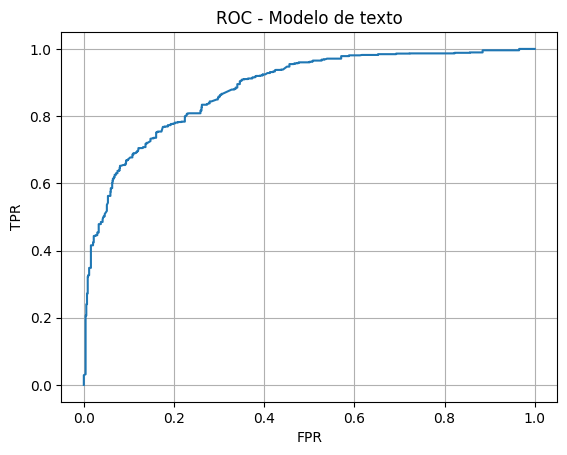

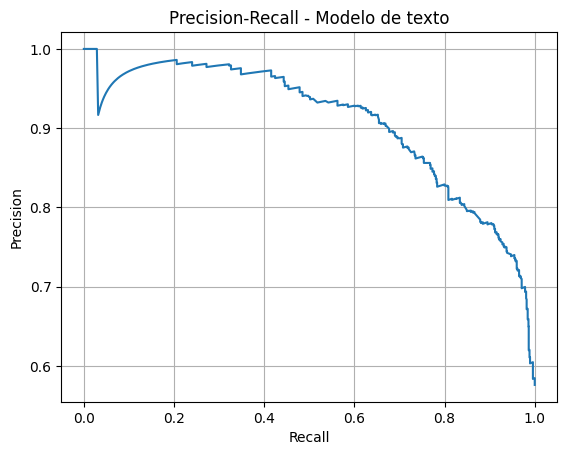

In [50]:
fpr, tpr, _ = roc_curve(y_test, proba)
prec, rec, _ = precision_recall_curve(y_test, proba)

plt.figure()
plt.plot(fpr, tpr)
plt.title("ROC - Modelo de texto")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(rec, prec)
plt.title("Precision-Recall - Modelo de texto")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

## 7. Búsqueda de umbral óptimo por F1

Se calcula el F1 para varios thresholds entre 0.1 y 0.9 y se elige el que
maximiza F1.

Mejor umbral por F1: 0.4 | F1: 0.837


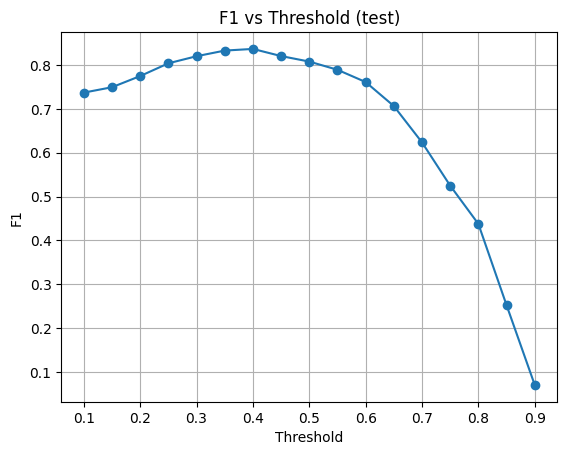

In [51]:
ths_grid = np.linspace(0.1, 0.9, 17)
f1s = []

for t in ths_grid:
    pred_t = (proba >= t).astype(int)
    f1s.append(f1_score(y_test, pred_t))

best_t = ths_grid[int(np.argmax(f1s))]
best_f1 = float(np.max(f1s))

print("Mejor umbral por F1:", round(best_t, 3), "| F1:", round(best_f1, 3))

plt.figure()
plt.plot(ths_grid, f1s, marker="o")
plt.title("F1 vs Threshold (test)")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.grid(True)
plt.show()

## 7.1. Umbral de demostración con mayor precisión

Además del umbral que maximiza F1, se busca un threshold que mantenga una
**precisión mínima** (por ejemplo ≥ 0.7).

Para evitar comportamientos raros (marcar como viables casos con probabilidad
~0.38–0.40 pero texto muy negativo), se fuerza que el umbral de demo **nunca
sea menor a 0.5**.

In [52]:
prec, rec, ths_pr = precision_recall_curve(y_test, proba)

target_prec = 0.7
mask = prec[:-1] >= target_prec  # 'ths_pr' tiene longitud len(prec) - 1

if not mask.any():
    print("No se encontró threshold con precisión >= ", target_prec, ".")
    thr_prec = 0.5
else:
    ths_valid = ths_pr[mask]
    rec_valid = rec[:-1][mask]
    thr_prec = float(ths_valid[rec_valid.argmax()])
    print(f"Threshold que mantiene prec ≥ {target_prec}: {round(thr_prec, 3)}")

# 🔹 UMBRAL DE DEMO DEFINITIVO (decisión de diseño):
thr_demo = 0.45   

print("Threshold automático por precisión (referencia):", round(thr_prec, 3))
print("Umbral de demo final (thr_demo):", round(thr_demo, 3))

pred_demo = (proba >= thr_demo).astype(int)
print("F1 con thr_demo:", round(f1_score(y_test, pred_demo), 3))

# Guardamos el umbral dentro del pipeline
setattr(pipe, "_thr_demo", float(thr_demo))


Threshold que mantiene prec ≥ 0.7: 0.277
Threshold automático por precisión (referencia): 0.277
Umbral de demo final (thr_demo): 0.45
F1 con thr_demo: 0.821


## 8. Revisión rápida de vocabulario

Se verifica que algunos tokens clave relacionados con negocio y montos estén
realmente presentes en el vocabulario de TF-IDF.

In [53]:
vec = pipe.named_steps["tfidf"]
tokens_check = ["mrr", "b2b", "usd", "semilla", "25k", "350k", "crecimiento"]
presentes = [t for t in tokens_check if t in vec.vocabulary_]

print("Tokens clave presentes en vocab:", presentes)

Tokens clave presentes en vocab: ['semilla', 'crecimiento']


## 9. Ejemplos de explicación de predicciones

Se prueba el modelo con descripciones ejemplo de startups que, a nivel
conceptual, deberían ser:

- Claramente viables.
- Claramente no viables (cerradas, en pausa, sin ingresos, con deudas).

Se usa `explicar_texto` con el `thr_demo` corregido.

In [54]:
from src.explainability.explicacion import explicar_texto

ejemplos_viables = [
    "Healthtech de telemedicina con 300 médicos registrados, más de 10 000 "
    "consultas realizadas, contratos con 3 clínicas privadas, MRR de 40k USD "
    "y crecimiento mensual del 25%.",

    "Plataforma B2B de logística para pymes con 2500 empresas activas, tickets "
    "promedio de 300 USD, retención del 85%, MRR superior a 60k USD y acuerdos "
    "firmados con dos cadenas de supermercados.",

    "Marketplace de educación en línea con 15 000 usuarios registrados, 1200 "
    "suscriptores de pago, crecimiento de 35% mensual en ventas y ronda semilla "
    "cerrada de 500k USD liderada por un fondo regional.",

    "SaaS de contabilidad para estudios contables con 800 clientes activos, "
    "churn menor al 3%, MRR de 25k USD y contrato anual firmado con una red de "
    "franquicias que agrupa a 200 estudios adicionales.",

    "Fintech de préstamos para microempresas con 5000 usuarios aprobados, tasa "
    "de morosidad controlada, partnership con una caja municipal y crecimiento "
    "de cartera superior al 20% trimestral."
]

ejemplos_no_viables = [
    "Idea de app para compartir gastos entre amigos, solo en fase conceptual, "
    "sin clientes, sin usuarios y sin ingresos. Aún no hay prototipo funcional "
    "ni validaciones con el mercado.",

    "Startup de e-commerce que operó un año pero fue cerrada por falta de ventas, "
    "acumula deudas con proveedores y no tiene clientes activos ni contratos vigentes.",

    "Proyecto de plataforma de cursos online con un prototipo básico sin pilotos, "
    "sin usuarios registrados y sin tracción. No se ha definido modelo de negocio "
    "ni fuentes claras de ingresos.",

    "Aplicación móvil para reservas de canchas deportivas en estado beta sin validar, "
    "solo 30 descargas, sin ventas y sin ingresos recurrentes, dependiente de un solo "
    "cliente que dejó de usar el servicio.",

    "Emprendimiento de delivery ecológico que tuvo algunos pedidos puntuales pero "
    "actualmente está en pausa, sin clientes activos, sin ingresos y con problemas "
    "financieros por deudas acumuladas."
]

def probar_ejemplos(lista_textos, etiqueta_esperada):
    print(f"\n===== Ejemplos esperados como: {etiqueta_esperada} =====")
    for i, txt in enumerate(lista_textos, start=1):
        res = explicar_texto(pipe, txt, thr=thr_demo)
        print(f"\nEjemplo {i}:")
        print("Descripción:", txt)
        print("Prob:", round(res["probabilidad"], 3), "| Viable (modelo):", res["viable"])
        print("→ Interpretación:", res["interpretacion"])
        print("→ Justificación técnica:", res["justificacion"])

probar_ejemplos(ejemplos_viables, "VIABLE")
probar_ejemplos(ejemplos_no_viables, "NO VIABLE")


===== Ejemplos esperados como: VIABLE =====

Ejemplo 1:
Descripción: Healthtech de telemedicina con 300 médicos registrados, más de 10 000 consultas realizadas, contratos con 3 clínicas privadas, MRR de 40k USD y crecimiento mensual del 25%.
Prob: 0.493 | Viable (modelo): True
→ Interpretación: La startup **sí parece viable** (probabilidad 0.49) porque menciona señales positivas como mensual 25, MRR y ingresos recurrentes (MRR).
→ Justificación técnica: Aportes: mensual 25:0.255; MRR:0.244; __tiene_mrr__:0.244; __crecimiento_medio__:0.078; crecimiento:0.033

Ejemplo 2:
Descripción: Plataforma B2B de logística para pymes con 2500 empresas activas, tickets promedio de 300 USD, retención del 85%, MRR superior a 60k USD y acuerdos firmados con dos cadenas de supermercados.
Prob: 0.433 | Viable (modelo): False
→ Interpretación: La startup **no parece viable** (probabilidad 0.43) porque no aparecen suficientes señales de tracción o madurez; lo más relevante fue MRR, ingresos recurrentes (MR

## 10. Guardado del modelo de texto

Finalmente se guarda el pipeline entrenado (`TF-IDF + LR + preprocesador`) en la
carpeta `models/` para reutilizarlo desde otros módulos del proyecto
(`entrenar_modelo.py`, `evaluar_modelo.py`, `streamlit_app.py`, etc.).

In [55]:
models_dir = PROJECT_ROOT / "models"
models_dir.mkdir(parents=True, exist_ok=True)

dump(pipe, models_dir / "modelo_texto.joblib")
print("Modelo guardado en:", models_dir / "modelo_texto.joblib")
print("thr_demo guardado en atributo _thr_demo:", getattr(pipe, "_thr_demo", None))

print("✅ Entrenamiento de modelo de texto completado y guardado correctamente.")

Modelo guardado en: c:\Users\carlo\OneDrive\Escritorio\Proyecto Machine Learning\models\modelo_texto.joblib
thr_demo guardado en atributo _thr_demo: 0.45
✅ Entrenamiento de modelo de texto completado y guardado correctamente.
